# Overview

This case study investigates how we can predict three zip codes that provide the best investment opportunity for the Syracuse Real Estate Investment Trust (SREIT). Using historical data of housing prices, it will calculate the compound average growth rate of every zip code from 1997 - 2018 in order to identify the zip codes with the best CAGR. After the data has been downsampled, linear regression will be performed using FBProphet to predict future house pricing trends.


## Research Objectives
This investigation is carried out in 3 parts:

#### 1. Exploratory Analysis
The data will be explored with a quick exercise by developing a time series plot for the Arkansas metropolitan areas of Hot Springs, Little Rock, Fayyetteville, and Searcy. The time series plot will be limited to the period of 1997 to present. 

#### 2. Downsampling
Due to the largeness of the dataset, downsapling will be performed through the measurement of Compound Annual Growth Rate (CAGR). The 10 zipcodes with the highest CAGR will be further investigated in part 3. 

#### 3. Forecasting
Regression models will be created for the 10 identified zip codes, using historical data from 1997 - 2017 as training data. Housing prices from 2018 will then be used to test the model and the Root Mean Squared Error will be calculated for each zip codes and used as a second metric to determine the best zip codes for investment.


## Data Cleaning and Preprocessing

Base data is provided by the IST 718 course via Zillow:(files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv) The data initially has 15,533 zip codes and 281 columns of data. 

The data must first be scrubbed and transformed from wide format to long format so that the housing prices can be grouped by year. 

Initial scrubbing changes formatting for consistency (i.e. column names to lower case, renaming of columns, etc.) The zipcode column also needs to be formatted so that leading 0's will still appear. Then, null values are identified and replaced or dropped. Finally, data types are transformed and the melt function is applied to flip the year columns to rows, which can then be grouped together by mean.



In [35]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

from math import sqrt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

import timeit
import datetime
import warnings

In [36]:
# Read in zillow data
zillow_df = pd.read_csv("Zip_Zhvi_SingleFamilyResidence.csv")

# print the first five rows of the data frame
print (pd.DataFrame.head(zillow_df))

   RegionID  RegionName     City State                             Metro  \
0     84654       60657  Chicago    IL          Chicago-Naperville-Elgin   
1     91982       77494     Katy    TX  Houston-The Woodlands-Sugar Land   
2     84616       60614  Chicago    IL          Chicago-Naperville-Elgin   
3     93144       79936  El Paso    TX                           El Paso   
4     91940       77449     Katy    TX  Houston-The Woodlands-Sugar Land   

       CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2018-04  \
0     Cook County         1  334200.0  335400.0  336500.0  ...  1038600   
1   Harris County         2  210400.0  212200.0  212200.0  ...   332600   
2     Cook County         3  498100.0  500900.0  503100.0  ...  1321000   
3  El Paso County         4   77300.0   77300.0   77300.0  ...   121300   
4   Harris County         5   95400.0   95600.0   95800.0  ...   176400   

   2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12  \
0  1041400  104

In [37]:
# Data Overview
print('data shape:', (zillow_df.shape))
print('data types:', (zillow_df.dtypes[1:25]))

data shape: (15533, 281)
data types: RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
1996-12       float64
1997-01       float64
1997-02       float64
1997-03       float64
1997-04       float64
1997-05       float64
1997-06       float64
1997-07       float64
1997-08       float64
1997-09       float64
dtype: object


In [38]:
zillow_df.describe()


,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
count,15533.000000,15533.000000,15533.000000,1.435200e+04,1.435200e+04,1.435200e+04,1.435200e+04,1.435200e+04,1.435200e+04,1.435200e+04,...,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04,1.553300e+04
mean,80780.222301,47669.525655,7767.000000,1.158027e+05,1.159205e+05,1.160363e+05,1.161491e+05,1.162727e+05,1.164157e+05,1.166034e+05,...,2.802374e+05,2.817488e+05,2.831092e+05,2.841684e+05,2.852049e+05,2.864123e+05,2.877066e+05,2.888305e+05,2.897778e+05,2.905968e+05
std,31496.834807,28985.566840,4484.135201,8.511917e+04,8.526739e+04,8.541614e+04,8.556951e+04,8.574677e+04,8.596132e+04,8.623299e+04,...,3.611161e+05,3.626860e+05,3.650263e+05,3.662374e+05,3.670201e+05,3.666675e+05,3.644700e+05,3.612256e+05,3.582214e+05,3.565128e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,2.170000e+04,2.220000e+04,2.220000e+04,2.200000e+04,2.180000e+04,2.170000e+04,2.150000e+04,2.160000e+04,2.190000e+04,2.200000e+04
25%,67247.000000,22306.000000,3884.000000,6.660000e+04,6.670000e+04,6.680000e+04,6.700000e+04,6.710000e+04,6.720000e+04,6.740000e+04,...,1.286000e+05,1.294000e+05,1.300000e+05,1.308000e+05,1.315000e+05,1.326000e+05,1.336000e+05,1.347000e+05,1.354000e+05,1.360000e+05
50%,77880.000000,45742.000000,7767.000000,9.650000e+04,9.670000e+04,9.670000e+04,9.690000e+04,9.690000e+04,9.700000e+04,9.710000e+04,...,1.919000e+05,1.931000e+05,1.942000e+05,1.953000e+05,1.965000e+05,1.977000e+05,1.991000e+05,2.007000e+05,2.017000e+05,2.026000e+05
75%,90300.000000,73801.000000,11650.000000,1.405000e+05,1.406000e+05,1.405250e+05,1.408000e+05,1.410000e+05,1.411000e+05,1.413000e+05,...,3.121000e+05,3.141000e+05,3.157000e+05,3.172000e+05,3.183000e+05,3.196000e+05,3.211000e+05,3.222000e+05,3.239000e+05,3.254000e+05
max,753844.000000,99901.000000,15533.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.742190e+07,1.744350e+07,1.771360e+07,1.800410e+07,1.826430e+07,1.831570e+07,1.810720e+07,1.761040e+07,1.694450e+07,1.651000e+07


In [39]:
# convert all dataset columns to lowercase 
zillow_df.columns = zillow_df.columns.str.lower()

# rename columns 
zillow_df = zillow_df.rename(columns={'regionname':'zipcode'}, index=str)

# ensure all zipcode columns are string so that 0's at the beginning still show
zillow_df['zipcode'] = zillow_df['zipcode'].astype('str').apply(lambda x: x.zfill(5))



In [40]:
# check for columns with NaN
zillow_df.columns[zillow_df.isna().any()].tolist()

# output shows that metro is the only categorical column with NaN. Therefore, replace NaN values in this column with 'unknown'
zillow_df['metro'] = zillow_df['metro'].fillna('unknown')

In order to melt the columns that contain the housing prices, the categorical variables and date columns need to be grouped together. For the initial exercise of creating a time series plot for the 4 metro areas of Arkansas, the timeframe requested is from 1997 to present. 

In [41]:
# group together id columns
id_columns = list(zillow_df.loc[:, 'regionid':'sizerank'])

# group together house price columns
date_columns = list(zillow_df.loc[:, '1997-01':'2019-01'])


In [42]:
zillow_melt = pd.melt(zillow_df, id_vars = id_columns, value_vars = date_columns, var_name='date', value_name='houseprice')
zillow_melt = zillow_melt.dropna()
zillow_melt.shape
zillow_melt.head()


,regionid,zipcode,city,state,metro,countyname,sizerank,date,houseprice
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1997-01,344400.0
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1997-01,197300.0
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1997-01,503400.0
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,1997-01,77800.0
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,1997-01,96600.0


Now that the data is presented in long form, the next step is to group the mean housing price by year. The 'date' column is transformed into a datetime type and referenced in order to create the new column 'year'. 

In [43]:
zillow_melt['date'] = pd.to_datetime(zillow_melt['date'], format='%Y-%m')

zillow_melt ['year'] = zillow_melt.date.dt.to_period('Y')

zillow_melt.head()

,regionid,zipcode,city,state,metro,countyname,sizerank,date,houseprice,year
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1997-01-01,344400.0,1997
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1997-01-01,197300.0,1997
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1997-01-01,503400.0,1997
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,1997-01-01,77800.0,1997
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,1997-01-01,96600.0,1997


In [44]:
zillow_group = zillow_melt.groupby(['regionid', 'zipcode', 'city', 'state', 'metro', 'countyname', 'sizerank', 'year', 'date'])['houseprice'].mean().reset_index()
zillow_group.head()


,regionid,zipcode,city,state,metro,countyname,sizerank,year,date,houseprice
0,58196,01001,Agawam,MA,Springfield,Hampden County,5955,1997,1997-01-01,111900.0
1,58196,01001,Agawam,MA,Springfield,Hampden County,5955,1997,1997-02-01,112100.0
2,58196,01001,Agawam,MA,Springfield,Hampden County,5955,1997,1997-03-01,112300.0
3,58196,01001,Agawam,MA,Springfield,Hampden County,5955,1997,1997-04-01,112500.0
4,58196,01001,Agawam,MA,Springfield,Hampden County,5955,1997,1997-05-01,112800.0


## PART 1: Develop a time series plot for Arkansas metro areas Hot Springs, Little Rock, Fayetteville, and Searcy

The data for each metro area is called and put into their own datasets. The identifiers used to call each metro area includes the state as well, in case there are multiple metropolitan areas with the same name outside of Arkansas. 

The four datasets are then concatnated into a new dataset, which is then used to find the mean of each metropolitan area by year. This is the dataset that is ultimately used to create the time series plot. 

In [45]:
# aggregate the data for the four metro areas
hot_springs = zillow_group.loc[(zillow_group['metro'] == 'Hot Springs') & (zillow_group['state'] == 'AR')]
little_rock = zillow_group.loc[(zillow_group['metro'].str.contains('Little Rock')) & (zillow_group['state'] == 'AR')]
fayetteville = zillow_group.loc[(zillow_group['metro'].str.contains('Fayetteville')) & (zillow_group['state'] == 'AR')]
searcy = zillow_group.loc[(zillow_group['metro'] == 'Searcy') & (zillow_group['state'] == 'AR')]

# merge
ar_df = pd.concat([hot_springs, little_rock, fayetteville, searcy], ignore_index=True)

print(ar_df.shape)
ar_df.head()


(15167, 10)


,regionid,zipcode,city,state,metro,countyname,sizerank,year,date,houseprice
0,89244,71901,Hot Springs,AR,Hot Springs,Garland County,2674,1997,1997-01-01,67000.0
1,89244,71901,Hot Springs,AR,Hot Springs,Garland County,2674,1997,1997-02-01,67000.0
2,89244,71901,Hot Springs,AR,Hot Springs,Garland County,2674,1997,1997-03-01,67000.0
3,89244,71901,Hot Springs,AR,Hot Springs,Garland County,2674,1997,1997-04-01,67100.0
4,89244,71901,Hot Springs,AR,Hot Springs,Garland County,2674,1997,1997-05-01,67200.0


In [46]:
ar_df = ar_df.groupby(['metro', 'date'])['houseprice'].mean().reset_index()
ar_df.head()

,metro,date,houseprice
0,Fayetteville-Springdale-Rogers,1997-01-01,82552.631579
1,Fayetteville-Springdale-Rogers,1997-02-01,83236.842105
2,Fayetteville-Springdale-Rogers,1997-03-01,83921.052632
3,Fayetteville-Springdale-Rogers,1997-04-01,84557.894737
4,Fayetteville-Springdale-Rogers,1997-05-01,85031.578947


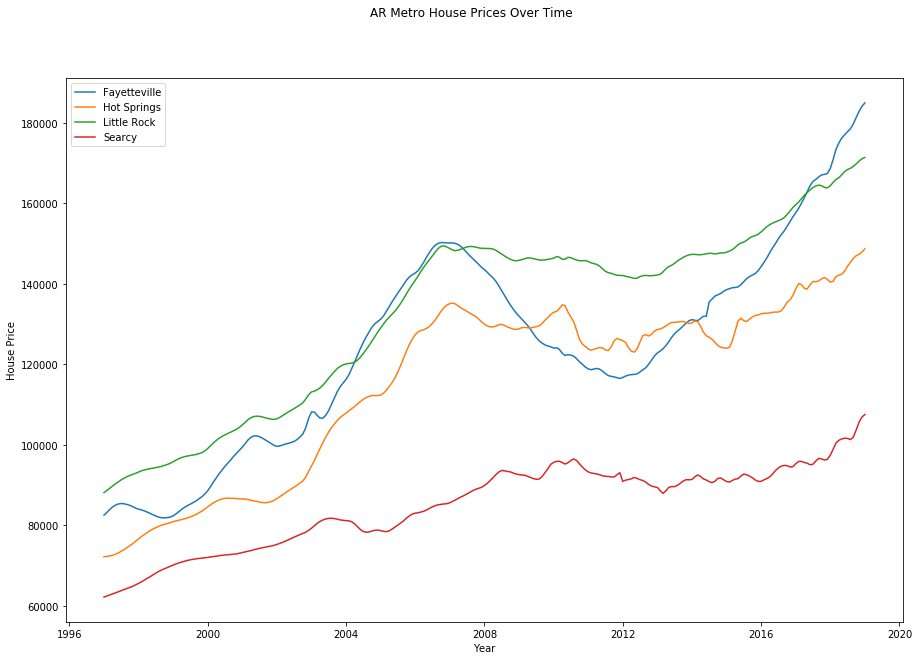

In [47]:
# time series plot of metro area house prices over time
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plot = sns.lineplot(x='date', y='houseprice', data=ar_df, hue='metro')
fig.suptitle('AR Metro House Prices Over Time')
ax.set_ylabel('House Price')
ax.set_xlabel('Year')
plt.gca().legend(('Fayetteville', 'Hot Springs', 'Little Rock', 'Searcy'))

## PART 2: Downsampling with CAGR

The ten best investment opportunties will be identified by looking at Compound Annual Growth Rate (CAGR) for each zip code. This will be completed by creating a column that calculates the CAGR based on the the housing prices at the beginning of 1997 and the end of 2018. The dataset will be sorted in descending order of CAGR to identify the zip codes with the best annual growth.

In [48]:
# create a copy of cleaned zillow dataset
CAGR_df = zillow_df[['zipcode','city','state','1997-01','2018-12']]

# calculate number of years
years = 2018-1997

# create new column based on the formula of CAGR
CAGR_df['CAGR'] = CAGR_df.iloc[:, 3].div(CAGR_df.iloc[:, -1]).pow(1./(years) - 1).sub(1)

# sort rows by value of CAGR descending
CAGR_df=CAGR_df.sort_values(by='CAGR', ascending=False)

CAGR_df=CAGR_df.head(10)

CAGR_df


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,zipcode,city,state,1997-01,2018-12,CAGR
690,19146,Philadelphia,PA,21400.0,334300,12.704988
1159,11222,New York,NY,146600.0,1703900,9.341441
104,11211,New York,NY,133100.0,1492900,8.996770
476,11216,New York,NY,154100.0,1566000,8.099913
12207,11930,Amagansett,NY,320300.0,3196400,7.943918
167,07302,Jersey City,NJ,143500.0,1387900,7.681153
14538,11975,Wainscott,NY,390900.0,3755400,7.625822
105,11215,New York,NY,249800.0,2181600,6.877066
1837,90291,Los Angeles,CA,238500.0,2033600,6.699356
3560,19125,Philadelphia,PA,32800.0,276000,6.603017


Looking at initial results, it seems like we have a very solid list of zipcodes that reflect substantial growth since 1997. But looking at the housing prices from December 2018, there is a large difference between the highest and lowest housing price. Let's graph the results to get better understanding of the data.

Text(0.5, 0, 'Year')

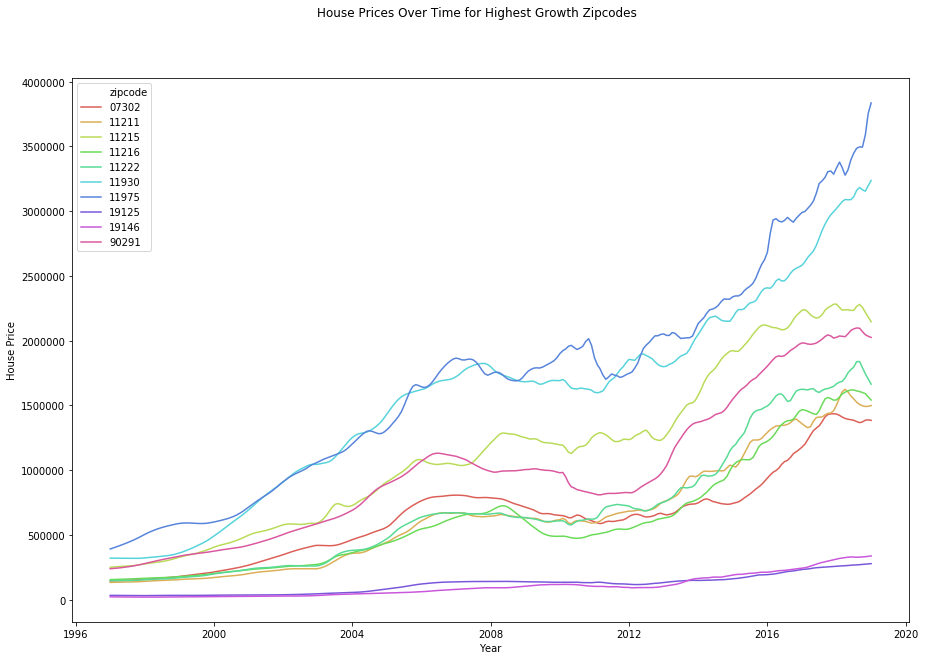

In [49]:
# aggregate the data for the 10 top zipcodes
zip_1 = zillow_group.loc[(zillow_group['zipcode'] == '19146')]
zip_2 = zillow_group.loc[(zillow_group['zipcode'] == '11222')]
zip_3 = zillow_group.loc[(zillow_group['zipcode'] == '11211')]
zip_4 = zillow_group.loc[(zillow_group['zipcode'] == '11216')]
zip_5 = zillow_group.loc[(zillow_group['zipcode'] == '11930')]
zip_6 = zillow_group.loc[(zillow_group['zipcode'] == '07302')]
zip_7 = zillow_group.loc[(zillow_group['zipcode'] == '11975')]
zip_8 = zillow_group.loc[(zillow_group['zipcode'] == '11215')]
zip_9 = zillow_group.loc[(zillow_group['zipcode'] == '90291')]
zip_10 = zillow_group.loc[(zillow_group['zipcode'] == '19125')]
                              
# merge
zip_df = pd.concat([zip_1, zip_2, zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9,zip_10], ignore_index=True)

zip_df = zip_df.groupby(['zipcode', 'date', 'metro'])['houseprice'].mean().reset_index()

# time series plot of metro area house prices over time
fig, ax2 = plt.subplots()
fig.set_size_inches(15, 10)
palette = sns.color_palette('hls', 10)
plot = sns.lineplot(x='date', y='houseprice', data=zip_df, hue='zipcode',  palette=palette)
fig.suptitle('House Prices Over Time for Highest Growth Zipcodes')
ax2.set_ylabel('House Price')
ax2.set_xlabel('Year')

Results initially show that 19146 (Philadelphia), 11222 (New York), and 11211 (New York) have the highest rate of compound annual growth from the years 1997 - 2018, which would theoretically make them the top contenders for the SREIT fund. 

However, upon further analysis of the visualized data, it is clear that the two zip codes from New York, which demonstrate enormous growth, are actually very pricey.

Thus, we will attempt the CAGR analysis again -- only this time, we will filter out all recent house prices above $500,000 to allow for maximal growth potential. 

In [50]:
# create a copy of cleaned zillow dataset
CAGR_df2 = zillow_df[['zipcode','city','state','1997-01','2018-12']]

CAGR_df2 = CAGR_df2[(CAGR_df2['2018-12'] < 500000)] #filter out values above 500000 

# calculate number of years
years = 2018-1997

# create new column based on the formula of CAGR
CAGR_df2['CAGR'] = CAGR_df2.iloc[:, 3].div(CAGR_df2.iloc[:, -1]).pow(1./(years) - 1).sub(1)

# sort rows by value of CAGR descending
CAGR_df2=CAGR_df2.sort_values(by='CAGR', ascending=False)

CAGR_df2=CAGR_df2.head(10)

CAGR_df2

,zipcode,city,state,1997-01,2018-12,CAGR
690,19146,Philadelphia,PA,21400.0,334300,12.704988
3560,19125,Philadelphia,PA,32800.0,276000,6.603017
14931,80449,Hartsel,CO,34600.0,282400,6.385333
14377,19951,Harbeson,DE,39300.0,302000,5.973363
802,19147,Philadelphia,PA,53800.0,412300,5.955291
13969,28617,Crumpler,NC,16500.0,124500,5.853160
4694,29403,Charleston,SC,66300.0,483100,5.629045
5057,19123,Philadelphia,PA,58700.0,417600,5.479554
6789,30317,Atlanta,GA,57300.0,401900,5.392628
7972,71241,Farmerville,LA,19300.0,130900,5.191455


Text(0.5, 0, 'Year')

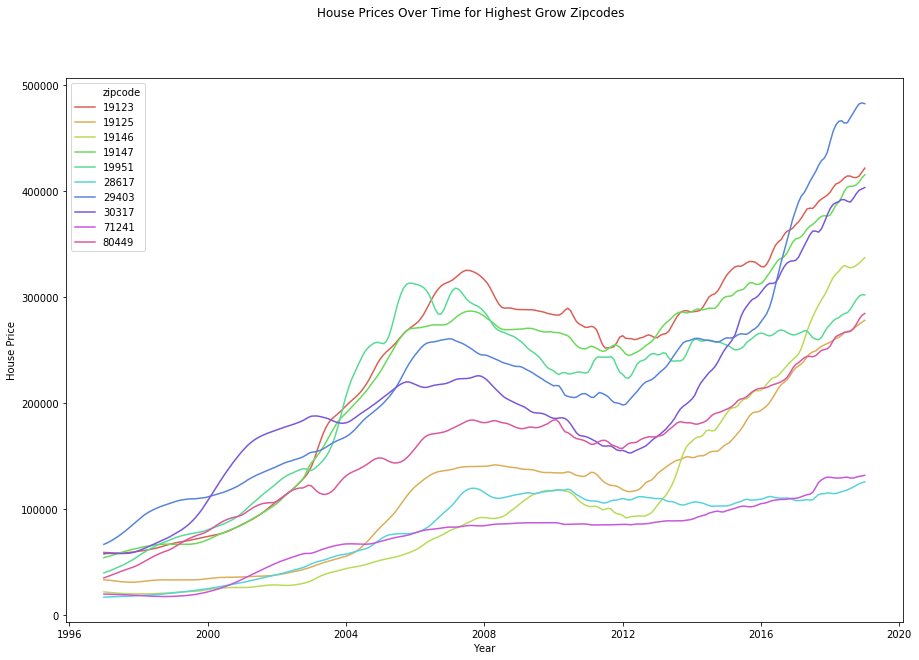

In [51]:
# aggregate the data for the 10 top zipcodes
zip_11 = zillow_group.loc[(zillow_group['zipcode'] == '19146')]
zip_12 = zillow_group.loc[(zillow_group['zipcode'] == '19125')]
zip_13 = zillow_group.loc[(zillow_group['zipcode'] == '80449')]
zip_14 = zillow_group.loc[(zillow_group['zipcode'] == '19951')]
zip_15 = zillow_group.loc[(zillow_group['zipcode'] == '19147')]
zip_16 = zillow_group.loc[(zillow_group['zipcode'] == '28617')]
zip_17 = zillow_group.loc[(zillow_group['zipcode'] == '29403')]
zip_18 = zillow_group.loc[(zillow_group['zipcode'] == '19123')]
zip_19 = zillow_group.loc[(zillow_group['zipcode'] == '30317')]
zip_20 = zillow_group.loc[(zillow_group['zipcode'] == '71241')]

# merge
zip_df2 = pd.concat([zip_11,zip_12,zip_13,zip_14,zip_15,zip_16,zip_17,zip_18,zip_19,zip_20], ignore_index=True)

zip_df2 = zip_df2.groupby(['zipcode', 'date', 'metro'])['houseprice'].mean().reset_index()

# time series plot of metro area house prices over time
fig, ax3 = plt.subplots()
fig.set_size_inches(15, 10)
palette = sns.color_palette('hls', 10)
plot = sns.lineplot(x='date', y='houseprice', data=zip_df2, hue='zipcode',  palette=palette)
fig.suptitle('House Prices Over Time for Highest Grow Zipcodes')
ax3.set_ylabel('House Price')
ax3.set_xlabel('Year')


## PART 3: FORECASTING WITH PROPHET

So far, the zipcodes of 19146, 19125, and 80449 look the most promising as they exhibit affordable median housing prices and have the highest growth rates in this tier. To further solidify the options, linear regression models will be computed for all 10 zipcodes for the CAGR_df2. 

The melted zillow data (zillow_group) must be further processed in order to create the model. First, the dataset needs to be broken out into training and testing datasets for each zip code. Then, training set for each zip code will be run through fbprophet. The Root Mean Square Error will be computed based on the prediction of the model and saved into a new column of CAGR_df2 to provide another decision metric.

RMSE is calculated by finding the square root of the mean squared error, which is computed using mean_squared_error from the sklearn.metrics.
 

In [52]:
# reorganize zillow_group columns
zillow_group = zillow_group.drop(['regionid'],axis=1)
cols = ['date', 'zipcode','countyname','metro','city','state', 'sizerank', 'houseprice', 'year']
zillow_group = zillow_group[cols]

zillow_group.head(25)

,date,zipcode,countyname,metro,city,state,sizerank,houseprice,year
0,1997-01-01,01001,Hampden County,Springfield,Agawam,MA,5955,111900.0,1997
1,1997-02-01,01001,Hampden County,Springfield,Agawam,MA,5955,112100.0,1997
2,1997-03-01,01001,Hampden County,Springfield,Agawam,MA,5955,112300.0,1997
3,1997-04-01,01001,Hampden County,Springfield,Agawam,MA,5955,112500.0,1997
4,1997-05-01,01001,Hampden County,Springfield,Agawam,MA,5955,112800.0,1997
5,1997-06-01,01001,Hampden County,Springfield,Agawam,MA,5955,113000.0,1997
6,1997-07-01,01001,Hampden County,Springfield,Agawam,MA,5955,113300.0,1997
7,1997-08-01,01001,Hampden County,Springfield,Agawam,MA,5955,113600.0,1997
8,1997-09-01,01001,Hampden County,Springfield,Agawam,MA,5955,113900.0,1997
9,1997-10-01,01001,Hampden County,Springfield,Agawam,MA,5955,114200.0,1997


In [53]:
train = zillow_group[(zillow_group['year'] <= 2017)]
test = zillow_group[(zillow_group['year'] == 2018)]

print(train.shape)
print(test.shape)
test.head(5)

(3746024, 9)
(186396, 9)


,date,zipcode,countyname,metro,city,state,sizerank,houseprice,year
252,2018-01-01,01001,Hampden County,Springfield,Agawam,MA,5955,222600.0,2018
253,2018-02-01,01001,Hampden County,Springfield,Agawam,MA,5955,222900.0,2018
254,2018-03-01,01001,Hampden County,Springfield,Agawam,MA,5955,223500.0,2018
255,2018-04-01,01001,Hampden County,Springfield,Agawam,MA,5955,224200.0,2018
256,2018-05-01,01001,Hampden County,Springfield,Agawam,MA,5955,224900.0,2018


In [54]:
# first, create a univariate model of just one zip code to try it out
train1 = train[train['zipcode'] == '19146']
test1 = test[test['zipcode'] == '19146']

train1_uni = train1[['zipcode','date','houseprice']]
test1_uni = test1[['zipcode','date','houseprice']]

test1_uni


,zipcode,date,houseprice
865816,19146,2018-01-01,312900.0
865817,19146,2018-02-01,318300.0
865818,19146,2018-03-01,321400.0
865819,19146,2018-04-01,324000.0
865820,19146,2018-05-01,327600.0
865821,19146,2018-06-01,329600.0
865822,19146,2018-07-01,328400.0
865823,19146,2018-08-01,327300.0
865824,19146,2018-09-01,328000.0
865825,19146,2018-10-01,329600.0


In [55]:
# renaming columns for prophet compatability
train1_uni = train1_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test1_uni = test1_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test1_uni.head()

,zipcode,ds,y
865816,19146,2018-01-01,312900.0
865817,19146,2018-02-01,318300.0
865818,19146,2018-03-01,321400.0
865819,19146,2018-04-01,324000.0
865820,19146,2018-05-01,327600.0


In [56]:
# create a model using Prophet
m = Prophet()
m.fit(train1_uni)

future = m.make_future_dataframe(periods = 12, freq = 'MS')
future.tail()

forecast = m.predict(future)
summary=forecast[['ds', 'yhat']].tail(12)
predictions = summary.iloc[-12:]
predictions # copy only 2018 data into new dataframe

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,yhat
252,2018-01-01,290392.245121
253,2018-02-01,293584.619270
254,2018-03-01,296506.681068
255,2018-04-01,299312.155717
256,2018-05-01,302230.126219
257,2018-06-01,305338.812152
258,2018-07-01,308325.149408
259,2018-08-01,311293.105502
260,2018-09-01,314310.363538
261,2018-10-01,317504.975211


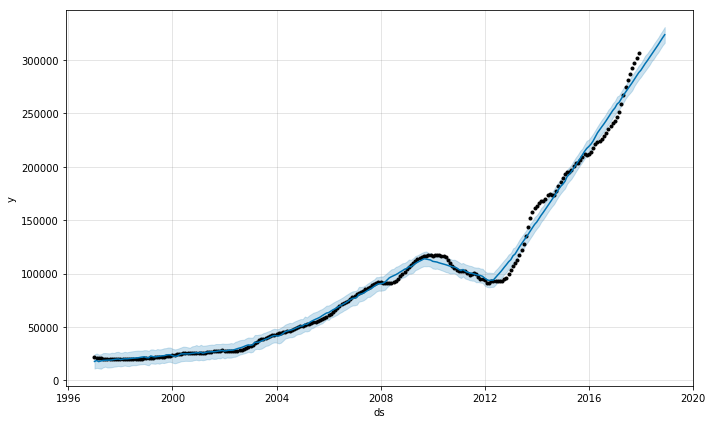

In [57]:
fig1 = m.plot(forecast)

In [58]:
#set indexes for dataframes
test1_uni.set_index('ds')
predictions.set_index('ds')

test1_uni.index = predictions.index

# merge forecasted data with test data set
results = pd.merge(test1_uni,predictions, how='left', on='ds')

# calculate error column
results['error']=results.yhat-results.y

results.tail(12)


,zipcode,ds,y,yhat,error
0,19146,2018-01-01,312900.0,290392.245121,-22507.754879
1,19146,2018-02-01,318300.0,293584.619270,-24715.380730
2,19146,2018-03-01,321400.0,296506.681068,-24893.318932
3,19146,2018-04-01,324000.0,299312.155717,-24687.844283
4,19146,2018-05-01,327600.0,302230.126219,-25369.873781
5,19146,2018-06-01,329600.0,305338.812152,-24261.187848
6,19146,2018-07-01,328400.0,308325.149408,-20074.850592
7,19146,2018-08-01,327300.0,311293.105502,-16006.894498
8,19146,2018-09-01,328000.0,314310.363538,-13689.636462
9,19146,2018-10-01,329600.0,317504.975211,-12095.024789


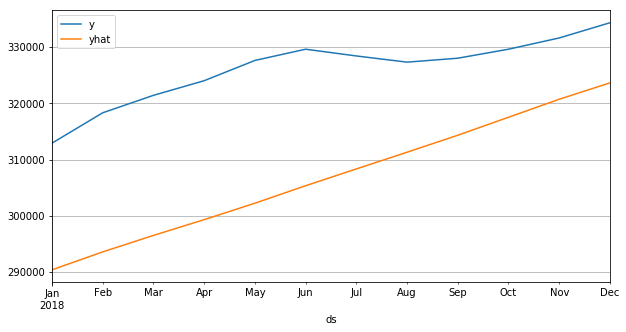

In [59]:
# line plot to compare predicted results vs. true results
results.plot(x='ds', y=['y', 'yhat'], figsize=(10,5), grid=True)

In [60]:
# calculate Root Mean Squared Error
rms = np.sqrt(mean_squared_error(results.y, results.yhat))
rms #20009.363188320047

20009.363188320047

In [61]:
train2 = train[train['zipcode'] == '19125']
test2 = test[test['zipcode'] == '19125']

train2_uni = train2[['zipcode','date','houseprice']]
test2_uni = test2[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train2_uni = train2_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test2_uni = test2_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test2_uni.head()


# create a model using Prophet
m2 = Prophet()
m2.fit(train2_uni)

future2 = m2.make_future_dataframe(periods = 12, freq = 'MS')

forecast2 = m2.predict(future2)
summary2=forecast2[['ds', 'yhat']].tail(12)
predictions2 = summary2.iloc[-12:]


#set indexes for dataframes
test2_uni.set_index('ds')
predictions2.set_index('ds')

test2_uni.index = predictions2.index

# merge forecasted data with test data set
results2 = pd.merge(test2_uni,predictions2, how='left', on='ds')

# calculate error column
results2['error']=results2.yhat-results2.y

results2.tail(12)

rms2 = np.sqrt(mean_squared_error(results2.y, results2.yhat))
rms2 #2610.831148121914

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


2610.831148121914

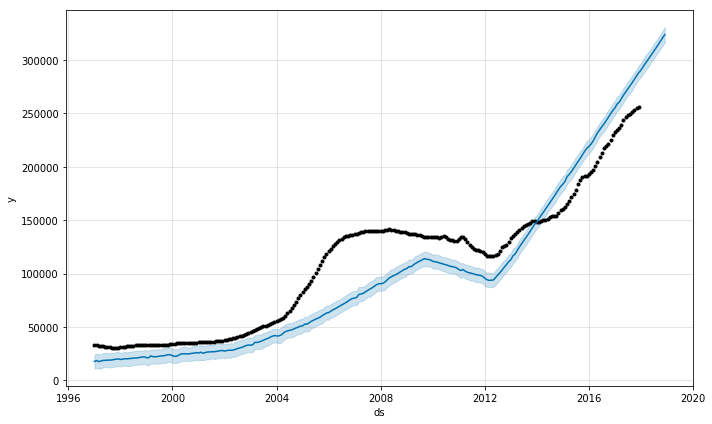

In [62]:
fig2 = m2.plot(forecast)

In [63]:
train3 = train[train['zipcode'] == '80449']
test3 = test[test['zipcode'] == '80449']

train3_uni = train3[['zipcode','date','houseprice']]
test3_uni = test3[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train3_uni = train3_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test3_uni = test3_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test3_uni.head()


# create a model using Prophet
m3 = Prophet()
m3.fit(train3_uni)

future3 = m3.make_future_dataframe(periods = 12, freq = 'MS')

forecast3 = m3.predict(future3)
summary3=forecast3[['ds', 'yhat']].tail(12)
predictions3 = summary3.iloc[-12:]


#set indexes for dataframes
test3_uni.set_index('ds')
predictions3.set_index('ds')

test3_uni.index = predictions3.index

# merge forecasted data with test data set
results3 = pd.merge(test3_uni,predictions3, how='left', on='ds')

# calculate error column
results3['error']=results3.yhat-results3.y

rms3 = np.sqrt(mean_squared_error(results3.y, results3.yhat))
rms3 #10661.54678617252

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


10661.54678617252

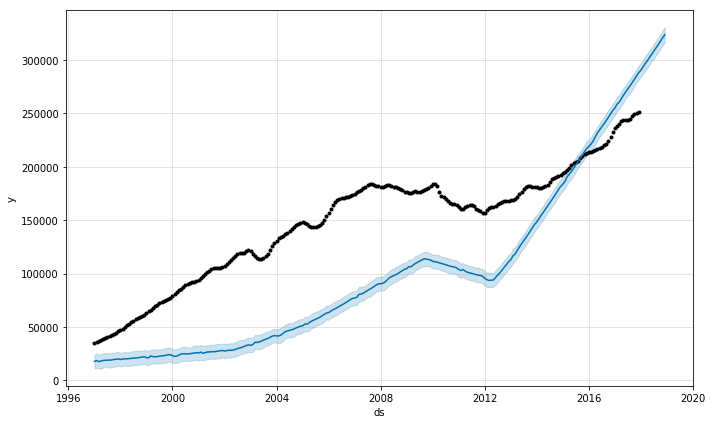

In [64]:
fig3 = m3.plot(forecast)

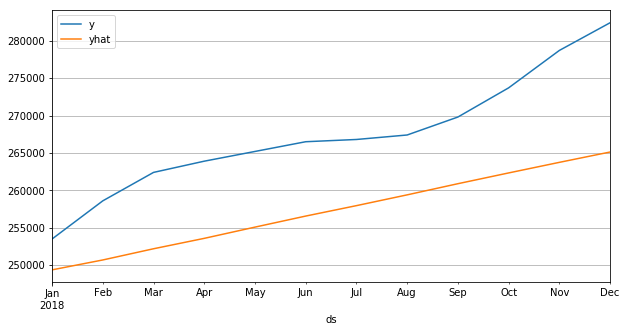

In [295]:
results3.plot(x='ds', y=['y', 'yhat'], figsize=(10,5), grid=True)

In [65]:
train4 = train[train['zipcode'] == '19951']
test4 = test[test['zipcode'] == '19951']

train4_uni = train4[['zipcode','date','houseprice']]
test4_uni = test4[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train4_uni = train4_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test4_uni = test4_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test4_uni.head()


# create a model using Prophet
m4 = Prophet()
m4.fit(train4_uni)

future4 = m4.make_future_dataframe(periods = 12, freq = 'MS')

forecast4 = m4.predict(future4)
summary4=forecast4[['ds', 'yhat']].tail(12)
predictions4 = summary4.iloc[-12:]


#set indexes for dataframes
test4_uni.set_index('ds')
predictions4.set_index('ds')

test4_uni.index = predictions4.index

# merge forecasted data with test data set
results4 = pd.merge(test4_uni,predictions4, how='left', on='ds')

# calculate error column
results4['error']=results4.yhat-results4.y

rms4 = np.sqrt(mean_squared_error(results4.y, results4.yhat))
rms4 #15397.082609064577

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


15397.082609064577

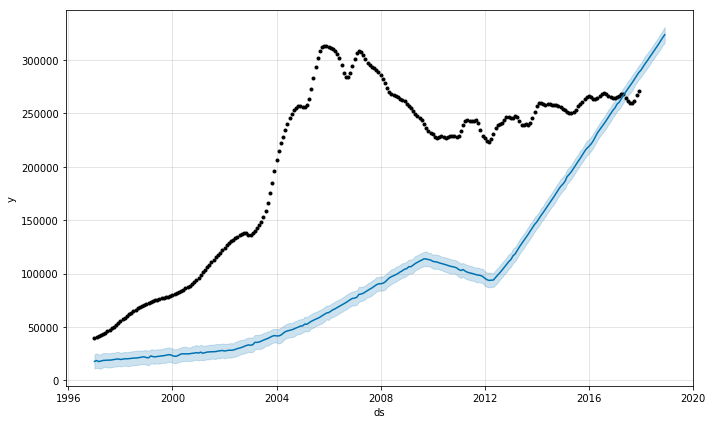

In [66]:
fig4 = m4.plot(forecast)

In [67]:
train5 = train[train['zipcode'] == '19147']
test5 = test[test['zipcode'] == '19147']

train5_uni = train5[['zipcode','date','houseprice']]
test5_uni = test5[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train5_uni = train5_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test5_uni = test5_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test5_uni.head()


# create a model using Prophet
m5 = Prophet()
m5.fit(train5_uni)

future5 = m5.make_future_dataframe(periods = 12, freq = 'MS')

forecast5 = m5.predict(future5)
summary5=forecast5[['ds', 'yhat']].tail(12)
predictions5 = summary5.iloc[-12:]


#set indexes for dataframes
test5_uni.set_index('ds')
predictions5.set_index('ds')

test5_uni.index = predictions5.index

# merge forecasted data with test data set
results5 = pd.merge(test5_uni,predictions5, how='left', on='ds')

# calculate error column
results5['error']=results5.yhat-results5.y

rms5 = np.sqrt(mean_squared_error(results5.y, results5.yhat))
rms5 #16930.75673504592

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


16930.75673504592

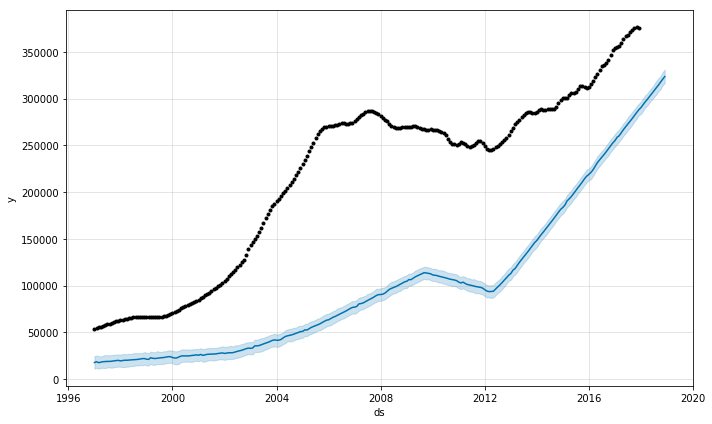

In [302]:
fig5 = m5.plot(forecast)

In [69]:
train6 = train[train['zipcode'] == '28617']
test6 = test[test['zipcode'] == '28617']

train6_uni = train6[['zipcode','date','houseprice']]
test6_uni = test6[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train6_uni = train6_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test6_uni = test6_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test6_uni.head()


# create a model using Prophet
m6 = Prophet()
m6.fit(train6_uni)

future6 = m6.make_future_dataframe(periods = 12, freq = 'MS')

forecast6 = m6.predict(future6)
summary6=forecast6[['ds', 'yhat']].tail(12)
predictions6 = summary6.iloc[-12:]


#set indexes for dataframes
test6_uni.set_index('ds')
predictions6.set_index('ds')

test6_uni.index = predictions6.index

# merge forecasted data with test data set
results6 = pd.merge(test6_uni,predictions6, how='left', on='ds')

# calculate error column
results6['error']=results6.yhat-results6.y

rms6 = np.sqrt(mean_squared_error(results6.y, results6.yhat))
rms6 #7825.614127349121


/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


7825.614127349121

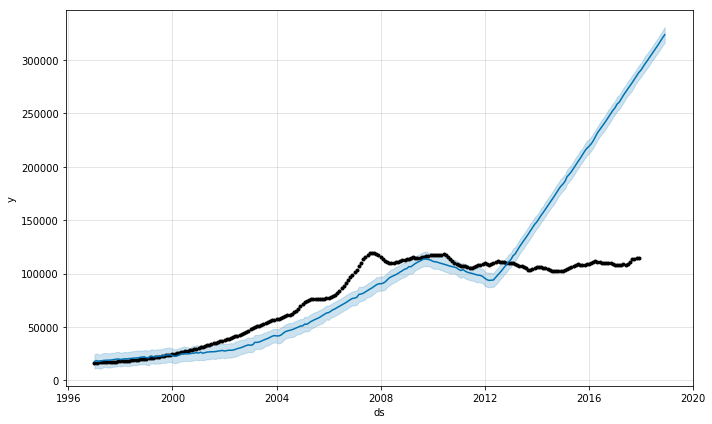

In [70]:
fig6 = m6.plot(forecast)

In [71]:
train7 = train[train['zipcode'] == '29403']
test7 = test[test['zipcode'] == '29403']

train7_uni = train7[['zipcode','date','houseprice']]
test7_uni = test7[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train7_uni = train7_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test7_uni = test7_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test7_uni.head()


# create a model using Prophet
m7 = Prophet()
m7.fit(train7_uni)

future7 = m7.make_future_dataframe(periods = 12, freq = 'MS')

forecast7 = m7.predict(future7)
summary7=forecast7[['ds', 'yhat']].tail(12)
predictions7 = summary7.iloc[-12:]


#set indexes for dataframes
test7_uni.set_index('ds')
predictions7.set_index('ds')

test7_uni.index = predictions7.index

# merge forecasted data with test data set
results7 = pd.merge(test7_uni,predictions7, how='left', on='ds')

# calculate error column
results7['error']=results7.yhat-results7.y

rms7 = np.sqrt(mean_squared_error(results7.y, results7.yhat))
rms7 #51881.05809445948


/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


51881.05809445948

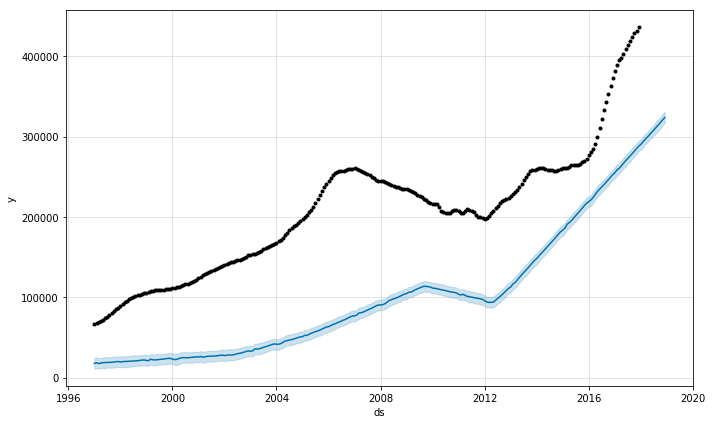

In [311]:
fig7 = m7.plot(forecast)

In [72]:
train8 = train[train['zipcode'] == '19123']
test8 = test[test['zipcode'] == '19123']

train8_uni = train8[['zipcode','date','houseprice']]
test8_uni = test8[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train8_uni = train8_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test8_uni = test8_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test8_uni.head()


# create a model using Prophet
m8 = Prophet()
m8.fit(train8_uni)

future8 = m8.make_future_dataframe(periods = 12, freq = 'MS')

forecast8 = m8.predict(future8)
summary8=forecast8[['ds', 'yhat']].tail(12)
predictions8 = summary8.iloc[-12:]


#set indexes for dataframes
test8_uni.set_index('ds')
predictions8.set_index('ds')

test8_uni.index = predictions8.index

# merge forecasted data with test data set
results8 = pd.merge(test8_uni,predictions8, how='left', on='ds')

# calculate error column
results8['error']=results8.yhat-results8.y

rms8 = np.sqrt(mean_squared_error(results8.y, results8.yhat))
rms8 #5037.458003055659


/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


5037.458003055659

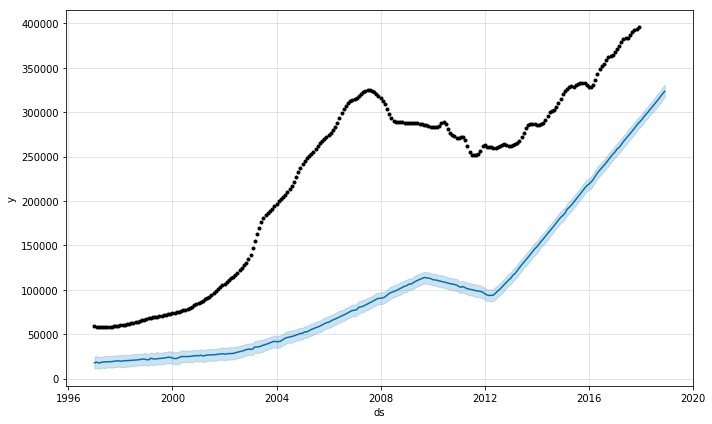

In [313]:
fig8 = m8.plot(forecast)

In [73]:
train9 = train[train['zipcode'] == '30317']
test9 = test[test['zipcode'] == '30317']

train9_uni = train9[['zipcode','date','houseprice']]
test9_uni = test9[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train9_uni = train9_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test9_uni = test9_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test9_uni.head()


# create a model using Prophet
m9 = Prophet()
m9.fit(train9_uni)

future9 = m9.make_future_dataframe(periods = 12, freq = 'MS')

forecast9 = m9.predict(future9)
summary9=forecast9[['ds', 'yhat']].tail(12)
predictions9 = summary9.iloc[-12:]


#set indexes for dataframes
test9_uni.set_index('ds')
predictions9.set_index('ds')

test9_uni.index = predictions9.index

# merge forecasted data with test data set
results9 = pd.merge(test9_uni,predictions9, how='left', on='ds')

# calculate error column
results9['error']=results9.yhat-results9.y

rms9 = np.sqrt(mean_squared_error(results9.y, results9.yhat))
rms9 #14113.845363551593

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


14113.845363551593

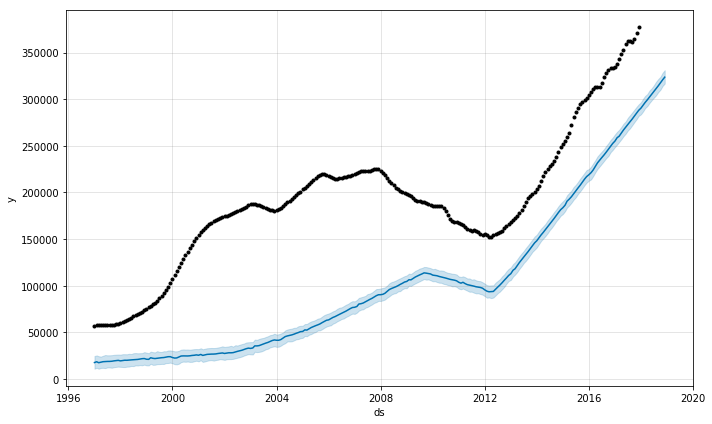

In [315]:
fig9 = m9.plot(forecast)

In [74]:
train10 = train[train['zipcode'] == '71241']
test10 = test[test['zipcode'] == '71241']

train10_uni = train10[['zipcode','date','houseprice']]
test10_uni = test10[['zipcode','date','houseprice']]

# renaming columns for prophet compatability
train10_uni = train10_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)
test10_uni = test10_uni.rename(columns={"date": "ds", "houseprice": "y"}, index=str)

test10_uni.head()


# create a model using Prophet
m10 = Prophet()
m10.fit(train10_uni)

future10 = m10.make_future_dataframe(periods = 12, freq = 'MS')

forecast10 = m10.predict(future10)
summary10=forecast10[['ds', 'yhat']].tail(12)
predictions10 = summary10.iloc[-12:]


#set indexes for dataframes
test10_uni.set_index('ds')
predictions10.set_index('ds')

test10_uni.index = predictions10.index

# merge forecasted data with test data set
results10 = pd.merge(test10_uni,predictions10, how='left', on='ds')

# calculate error column
results10['error']=results10.yhat-results10.y

rms10 = np.sqrt(mean_squared_error(results10.y, results10.yhat))
rms10 #5523.488619182996


/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


5523.488619182996

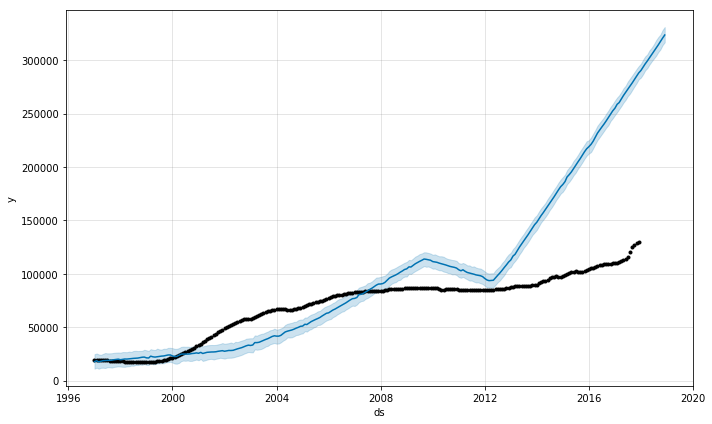

In [317]:
fig10 = m10.plot(forecast)

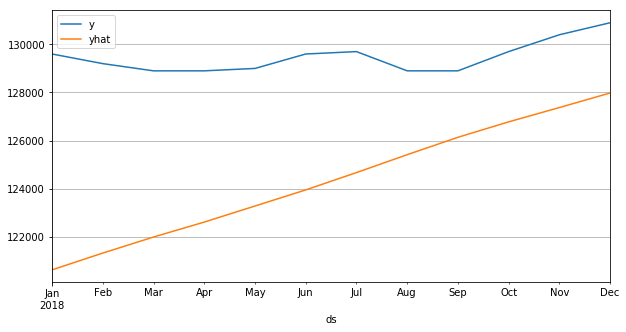

In [75]:
results10.plot(x='ds', y=['y', 'yhat'], figsize=(10,5), grid=True)

# Conclusion

Now that we have the preliminary information needed to make an educated investment decision, we will sort the table be descending CAGR, ascending RMSE, and descending housing prices in December of 2018. These three views will show us the zipcodes with the top growth rate, most stability, and most affordable housing costs respectively. This analysis will help us the recommendation. 

In [76]:
# Add RMSE values to CAGR_df2 
CAGR_df2['RMSE']=[rms,rms2,rms3,rms4,rms5,rms6,rms7,rms8,rms9,rms10]

# Set index
CAGR_df2=CAGR_df2.set_index('zipcode')

CAGR_df2


,city,state,1997-01,2018-12,CAGR,RMSE
zipcode,,,,,,
19146,Philadelphia,PA,21400.0,334300,12.704988,20009.363188
19125,Philadelphia,PA,32800.0,276000,6.603017,2610.831148
80449,Hartsel,CO,34600.0,282400,6.385333,10661.546786
19951,Harbeson,DE,39300.0,302000,5.973363,15397.082609
19147,Philadelphia,PA,53800.0,412300,5.955291,16930.756735
28617,Crumpler,NC,16500.0,124500,5.853160,7825.614127
29403,Charleston,SC,66300.0,483100,5.629045,51881.058094
19123,Philadelphia,PA,58700.0,417600,5.479554,5037.458003
30317,Atlanta,GA,57300.0,401900,5.392628,14113.845364


In [77]:
CAGR_df2=CAGR_df2.sort_values(by='RMSE', ascending=True)

CAGR_df2

,city,state,1997-01,2018-12,CAGR,RMSE
zipcode,,,,,,
19125,Philadelphia,PA,32800.0,276000,6.603017,2610.831148
19123,Philadelphia,PA,58700.0,417600,5.479554,5037.458003
71241,Farmerville,LA,19300.0,130900,5.191455,5523.488619
28617,Crumpler,NC,16500.0,124500,5.853160,7825.614127
80449,Hartsel,CO,34600.0,282400,6.385333,10661.546786
30317,Atlanta,GA,57300.0,401900,5.392628,14113.845364
19951,Harbeson,DE,39300.0,302000,5.973363,15397.082609
19147,Philadelphia,PA,53800.0,412300,5.955291,16930.756735
19146,Philadelphia,PA,21400.0,334300,12.704988,20009.363188


In [78]:
CAGR_df2=CAGR_df2.sort_values(by='2018-12', ascending=True)

CAGR_df2

,city,state,1997-01,2018-12,CAGR,RMSE
zipcode,,,,,,
28617,Crumpler,NC,16500.0,124500,5.853160,7825.614127
71241,Farmerville,LA,19300.0,130900,5.191455,5523.488619
19125,Philadelphia,PA,32800.0,276000,6.603017,2610.831148
80449,Hartsel,CO,34600.0,282400,6.385333,10661.546786
19951,Harbeson,DE,39300.0,302000,5.973363,15397.082609
19146,Philadelphia,PA,21400.0,334300,12.704988,20009.363188
30317,Atlanta,GA,57300.0,401900,5.392628,14113.845364
19147,Philadelphia,PA,53800.0,412300,5.955291,16930.756735
19123,Philadelphia,PA,58700.0,417600,5.479554,5037.458003


# Recommendation

Based on the results, the recommendation for the SREIT would be 19146, 19125, and 28917. 

### 19146 (Philadelphia, PA):
This is the top recommended zipcode because it exhibits enormous annual growth at 12.7%. It is also midrange in median housing price. The only downside of this zip code is that the RMSE is quite high. But, as the saying goes: high risk, high reward. 

### 19125 (Philadelphia, PA):
The next recommended zipcode derives from the fact that it has the lowest RMSE at 2610, in addition to having the 2nd highest CAGR within this batch. The low RMSE will help to balance out the portfolio, since 19146 is such high risk. 

### 28617 (Crumpler, NC):
The final recommended zipcode is 28617 because it has the lowest median housing cost, has an above average RMSE score. It is ranked #6 in terms of CAGR, but the low cost and above average stability make it a more worthwhile investment. 


# References

CAGR: https://www.investopedia.com/terms/c/cagr.asp

CAGR: https://stackoverflow.com/questions/37355924/pandas-calculate-cagr-with-slicing

FBProphet: https://facebook.github.io/prophet/docs/quick_start.html#python-api

RMSE: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d